In [19]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [20]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [21]:
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-08-25-06-06-input_route_rotate_diff")


cp_path = os.path.join(log_dir, "cp/last.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [22]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [23]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [24]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

tensor([[[1.6000, 8.9000],
         [1.7000, 9.1000],
         [1.9000, 9.2000],
         [2.0000, 9.4000],
         [2.1000, 9.7000],
         [2.0000, 9.9000],
         [1.8000, 9.9000],
         [1.7000, 9.9000],
         [1.6000, 9.8000],
         [1.4000, 9.5000],
         [1.1000, 9.3000],
         [0.7000, 9.4000],
         [0.4000, 9.3000],
         [0.3000, 9.2000],
         [0.0000, 9.1000],
         [0.0000, 8.9000],
         [0.2000, 8.6000],
         [0.4000, 8.3000],
         [0.5000, 8.1000],
         [0.6000, 7.8000],
         [0.7000, 7.6000],
         [0.9000, 7.2000],
         [1.0000, 7.0000],
         [1.2000, 6.7000],
         [1.2000, 6.4000],
         [1.2000, 6.3000],
         [1.2000, 6.1000],
         [1.2000, 5.6000],
         [1.5000, 5.3000],
         [1.6000, 5.1000],
         [1.9000, 5.0000],
         [2.4000, 4.9000],
         [2.7000, 4.9000],
         [2.9000, 4.9000],
         [2.9000, 5.0000],
         [2.9000, 5.1000],
         [2.9000, 5.3000],
 

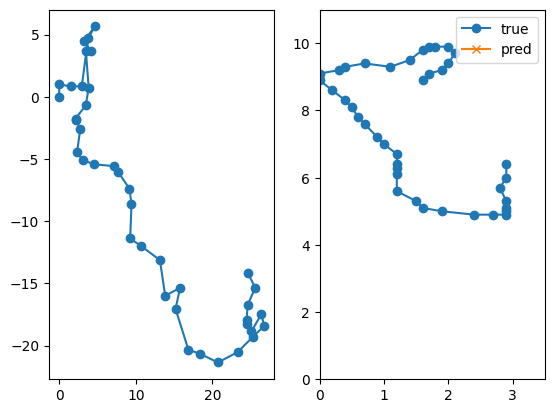

tensor([[[1.0000, 5.5000],
         [1.1000, 5.5000],
         [1.6000, 5.5000],
         [2.0000, 5.6000],
         [2.1000, 5.6000],
         [2.2000, 5.6000],
         [2.3000, 5.6000],
         [2.7000, 5.4000],
         [2.9000, 5.0000],
         [2.9000, 4.8000],
         [2.9000, 4.3000],
         [2.9000, 3.9000],
         [2.9000, 3.7000],
         [2.7000, 3.5000],
         [2.7000, 3.1000],
         [2.8000, 2.9000],
         [2.8000, 2.6000],
         [2.7000, 2.1000],
         [2.7000, 2.0000],
         [2.7000, 1.8000],
         [2.9000, 1.6000],
         [2.9000, 1.4000],
         [2.9000, 1.3000],
         [2.9000, 0.9000],
         [2.9000, 0.6000],
         [2.8000, 0.3000],
         [2.9000, 0.0000],
         [2.8000, 0.0000],
         [2.4000, 0.3000],
         [2.2000, 0.6000],
         [2.1000, 0.7000],
         [1.8000, 0.9000],
         [1.4000, 1.1000],
         [1.2000, 1.5000],
         [0.9000, 1.8000],
         [0.7000, 2.0000],
         [0.3000, 2.2000],
 

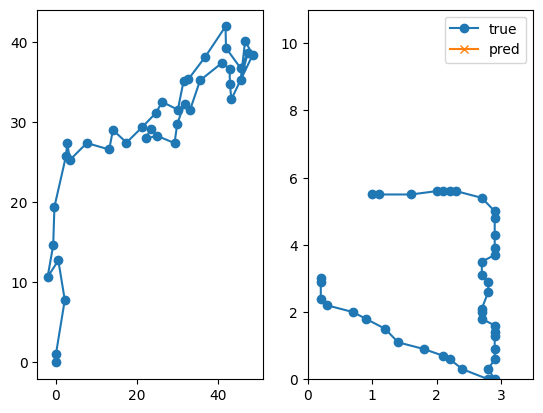

tensor([[[0.8000, 5.1000],
         [0.5000, 5.0000],
         [0.2000, 4.8000],
         [0.0000, 4.8000],
         [0.0000, 4.7000],
         [0.0000, 4.4000],
         [0.0000, 4.1000],
         [0.1000, 3.8000],
         [0.3000, 3.6000],
         [0.4000, 3.5000],
         [0.5000, 3.0000],
         [0.3000, 2.5000],
         [0.3000, 2.3000],
         [0.3000, 2.2000],
         [0.2000, 2.0000],
         [0.0000, 1.7000],
         [0.0000, 1.5000],
         [0.2000, 1.3000],
         [0.5000, 1.2000],
         [0.6000, 1.2000],
         [0.9000, 1.4000],
         [1.3000, 1.5000],
         [1.5000, 1.5000],
         [1.6000, 1.5000],
         [1.8000, 1.7000],
         [2.0000, 2.1000],
         [2.0000, 2.3000],
         [2.0000, 2.5000],
         [1.9000, 2.6000],
         [1.9000, 3.0000],
         [1.8000, 3.5000],
         [1.4000, 3.8000],
         [1.3000, 3.9000],
         [1.1000, 4.3000],
         [1.0000, 4.8000],
         [1.0000, 5.0000],
         [1.1000, 5.4000],
 

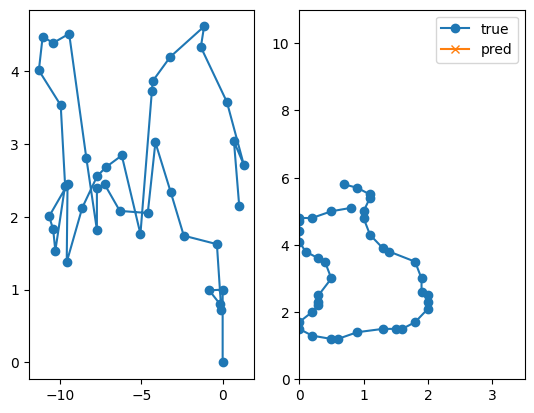

tensor([[[2.0000, 3.7000],
         [2.0000, 3.9000],
         [2.1000, 4.2000],
         [2.3000, 4.7000],
         [2.4000, 4.8000],
         [2.8000, 4.8000],
         [2.9000, 4.9000],
         [2.9000, 5.3000],
         [2.6000, 5.7000],
         [2.5000, 5.9000],
         [2.5000, 6.0000],
         [2.6000, 6.5000],
         [2.9000, 6.8000],
         [2.9000, 7.0000],
         [2.9000, 7.4000],
         [2.9000, 7.8000],
         [2.8000, 8.0000],
         [2.6000, 8.2000],
         [2.3000, 8.6000],
         [2.2000, 9.0000],
         [2.2000, 9.3000],
         [2.2000, 9.4000],
         [2.2000, 9.6000],
         [2.5000, 9.9000],
         [2.8000, 9.9000],
         [2.9000, 9.8000],
         [2.9000, 9.7000],
         [2.9000, 9.6000],
         [2.9000, 9.2000],
         [2.9000, 8.7000],
         [2.9000, 8.6000],
         [2.9000, 8.4000],
         [2.6000, 8.1000],
         [2.5000, 8.0000],
         [2.5000, 7.7000],
         [2.2000, 7.3000],
         [2.2000, 7.1000],
 

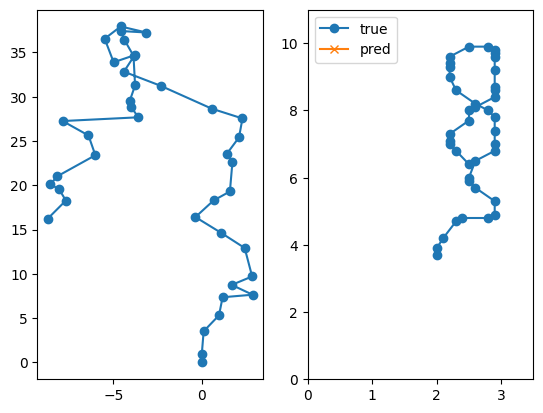

tensor([[[2.0000, 1.7000],
         [1.8000, 2.1000],
         [1.6000, 2.6000],
         [1.3000, 2.7000],
         [1.1000, 3.0000],
         [1.1000, 3.1000],
         [1.1000, 3.2000],
         [1.1000, 3.3000],
         [1.2000, 3.8000],
         [1.2000, 3.9000],
         [1.2000, 4.0000],
         [1.3000, 4.4000],
         [1.4000, 4.6000],
         [1.4000, 4.7000],
         [1.5000, 4.8000],
         [1.8000, 5.1000],
         [1.9000, 5.6000],
         [1.9000, 5.8000],
         [1.9000, 6.2000],
         [1.8000, 6.3000],
         [1.4000, 6.4000],
         [1.2000, 6.3000],
         [1.1000, 5.9000],
         [1.2000, 5.6000],
         [1.2000, 5.4000],
         [1.6000, 5.0000],
         [1.7000, 5.0000],
         [2.1000, 4.9000],
         [2.3000, 4.9000],
         [2.4000, 5.0000],
         [2.5000, 5.0000],
         [2.7000, 5.2000],
         [2.9000, 5.5000],
         [2.9000, 5.7000],
         [2.9000, 6.1000],
         [2.8000, 6.5000],
         [2.9000, 6.8000],
 

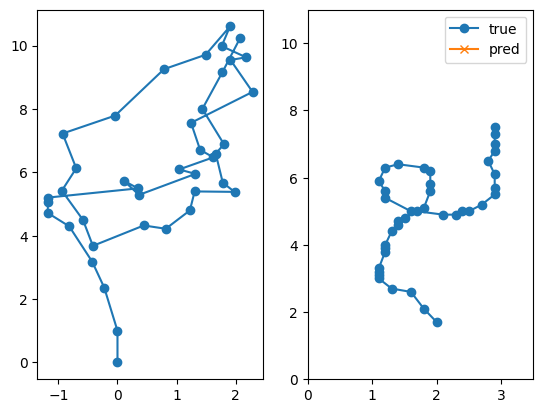

tensor([[[1.6000, 6.3000],
         [1.9000, 6.0000],
         [2.1000, 5.9000],
         [2.3000, 5.9000],
         [2.4000, 6.0000],
         [2.5000, 6.2000],
         [2.5000, 6.5000],
         [2.6000, 7.0000],
         [2.7000, 7.2000],
         [2.7000, 7.3000],
         [2.6000, 7.4000],
         [2.3000, 7.5000],
         [2.0000, 7.5000],
         [1.7000, 7.7000],
         [1.7000, 7.8000],
         [1.8000, 7.9000],
         [1.8000, 8.0000],
         [1.7000, 8.3000],
         [1.4000, 8.7000],
         [1.1000, 8.9000],
         [0.6000, 8.9000],
         [0.2000, 8.7000],
         [0.0000, 8.2000],
         [0.0000, 7.8000],
         [0.0000, 7.5000],
         [0.0000, 7.3000],
         [0.1000, 7.0000],
         [0.1000, 6.6000],
         [0.2000, 6.2000],
         [0.3000, 5.8000],
         [0.4000, 5.5000],
         [0.6000, 5.3000],
         [1.0000, 5.0000],
         [1.0000, 4.7000],
         [0.9000, 4.6000],
         [0.9000, 4.5000],
         [0.8000, 4.3000],
 

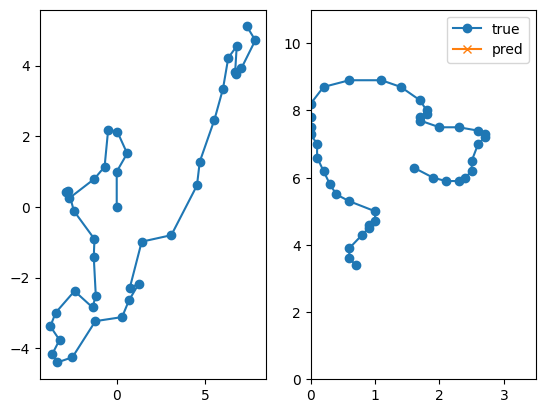

tensor([[[0.6000, 1.8000],
         [0.2000, 1.7000],
         [0.0000, 1.4000],
         [0.0000, 1.2000],
         [0.0000, 1.1000],
         [0.1000, 0.7000],
         [0.2000, 0.5000],
         [0.3000, 0.5000],
         [0.6000, 0.4000],
         [0.8000, 0.1000],
         [1.2000, 0.0000],
         [1.5000, 0.0000],
         [1.7000, 0.0000],
         [1.9000, 0.1000],
         [2.1000, 0.3000],
         [2.2000, 0.4000],
         [2.6000, 0.8000],
         [2.9000, 1.1000],
         [2.9000, 1.2000],
         [2.9000, 1.7000],
         [2.9000, 1.9000],
         [2.9000, 2.0000],
         [2.9000, 2.3000],
         [2.9000, 2.4000],
         [2.8000, 2.6000],
         [2.9000, 3.1000],
         [2.8000, 3.6000],
         [2.7000, 3.9000],
         [2.5000, 4.2000],
         [2.0000, 4.4000],
         [1.6000, 4.4000],
         [1.2000, 4.7000],
         [0.7000, 4.9000],
         [0.4000, 4.9000],
         [0.3000, 4.9000],
         [0.2000, 4.9000],
         [0.0000, 5.2000],
 

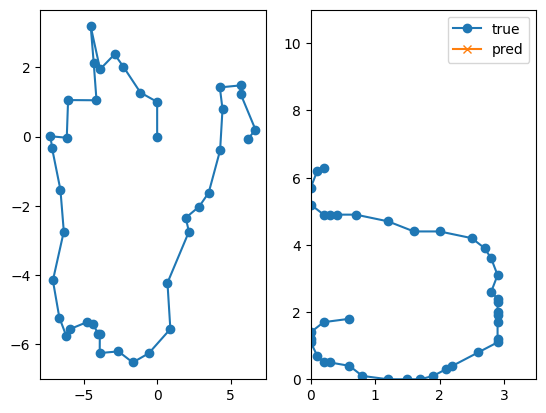

tensor([[[2.5000, 3.9000],
         [2.3000, 4.3000],
         [2.2000, 4.6000],
         [2.1000, 4.7000],
         [1.8000, 5.0000],
         [1.4000, 5.2000],
         [1.2000, 5.4000],
         [0.8000, 5.8000],
         [0.7000, 5.9000],
         [0.4000, 6.1000],
         [0.1000, 6.2000],
         [0.0000, 6.2000],
         [0.0000, 6.5000],
         [0.1000, 7.0000],
         [0.3000, 7.4000],
         [0.4000, 7.6000],
         [0.8000, 7.7000],
         [0.9000, 7.6000],
         [1.2000, 7.3000],
         [1.7000, 7.2000],
         [2.1000, 7.1000],
         [2.6000, 7.0000],
         [2.9000, 6.8000],
         [2.9000, 6.5000],
         [2.9000, 6.3000],
         [2.9000, 6.2000],
         [2.9000, 6.1000],
         [2.9000, 6.0000],
         [2.9000, 5.9000],
         [2.7000, 5.6000],
         [2.2000, 5.5000],
         [2.1000, 5.5000],
         [1.9000, 5.4000],
         [1.5000, 5.4000],
         [1.3000, 5.4000],
         [1.2000, 5.4000],
         [0.7000, 5.5000],
 

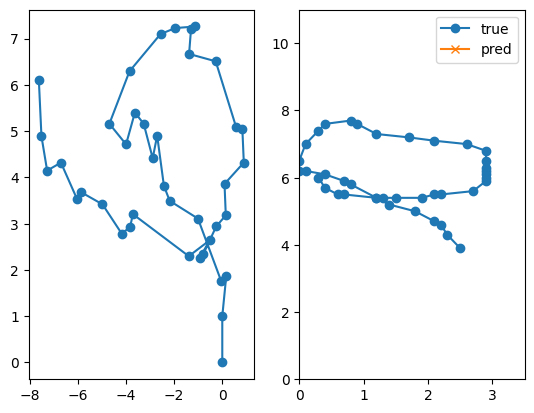

tensor([[[1.0000, 9.8000],
         [0.8000, 9.9000],
         [0.7000, 9.9000],
         [0.2000, 9.9000],
         [0.0000, 9.8000],
         [0.0000, 9.7000],
         [0.1000, 9.5000],
         [0.2000, 9.0000],
         [0.3000, 8.8000],
         [0.4000, 8.3000],
         [0.4000, 8.0000],
         [0.3000, 7.8000],
         [0.3000, 7.7000],
         [0.3000, 7.6000],
         [0.5000, 7.3000],
         [0.5000, 7.2000],
         [0.5000, 7.1000],
         [0.7000, 6.7000],
         [1.0000, 6.5000],
         [1.2000, 6.1000],
         [1.2000, 5.6000],
         [1.2000, 5.5000],
         [1.4000, 5.0000],
         [1.5000, 4.9000],
         [1.9000, 4.6000],
         [2.2000, 4.3000],
         [2.6000, 4.0000],
         [2.8000, 4.0000],
         [2.9000, 4.0000],
         [2.9000, 4.1000],
         [2.9000, 4.3000],
         [2.8000, 4.8000],
         [2.5000, 5.1000],
         [2.4000, 5.4000],
         [2.3000, 5.5000],
         [1.9000, 5.5000],
         [1.8000, 5.5000],
 

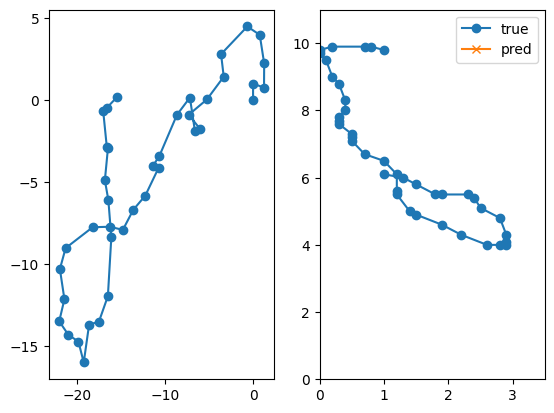

tensor([[[1.1000, 0.1000],
         [1.3000, 0.5000],
         [1.6000, 0.6000],
         [2.0000, 0.5000],
         [2.4000, 0.6000],
         [2.6000, 0.8000],
         [2.8000, 1.0000],
         [2.9000, 1.0000],
         [2.9000, 1.2000],
         [2.9000, 1.7000],
         [2.7000, 1.9000],
         [2.7000, 2.1000],
         [2.5000, 2.5000],
         [2.2000, 2.8000],
         [2.1000, 3.3000],
         [1.9000, 3.6000],
         [1.7000, 3.7000],
         [1.3000, 3.8000],
         [1.0000, 3.7000],
         [0.8000, 3.5000],
         [0.8000, 3.4000],
         [0.8000, 3.2000],
         [0.9000, 2.7000],
         [1.2000, 2.3000],
         [1.3000, 2.0000],
         [1.6000, 1.8000],
         [1.9000, 1.6000],
         [2.4000, 1.7000],
         [2.6000, 1.9000],
         [2.7000, 2.4000],
         [2.8000, 2.5000],
         [2.8000, 2.7000],
         [2.9000, 3.0000],
         [2.9000, 3.4000],
         [2.7000, 3.6000],
         [2.5000, 3.8000],
         [2.3000, 3.9000],
 

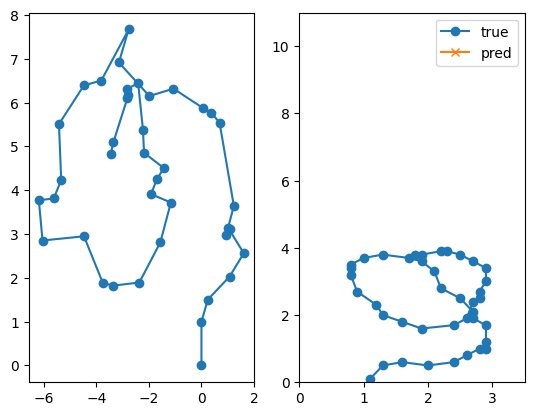

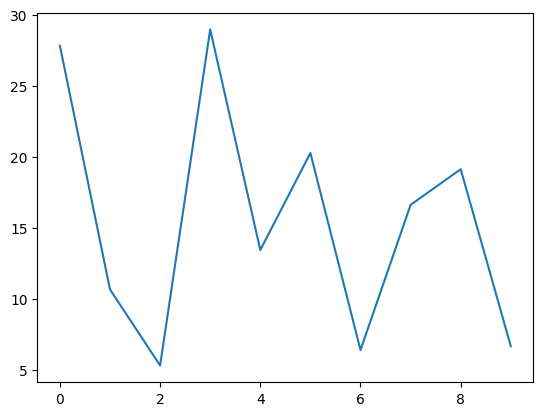

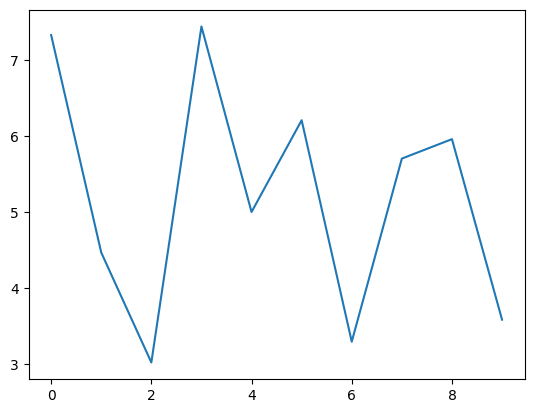

15.518237161636353


In [25]:

ut.fix_seeds(0)
df = pickle.load(open(DF_PATH, "rb"))
config = conf.from_yaml(config_path)

model = models.get_model(config["model"])
route_gen = routes.get_route_generator(config["route"])
dataset = datasets.get_dataset(config["dataset"])
dm = datamodules.get_dm(config["dm"])

dataset.set_route(df, route_gen)
dm.setDataset(dataset)


model.eval()


loss_list = []
dist_list = []
for i in range(10):
    # batch = dm.train_dataset[i]
    batch = dm.val_dataset[i]
    # batch = dm.test_dataset[i]
    x, y = batch
    x = x.unsqueeze(0)

    mean = 0.0  # 平均
    std = 0.381  # 標準偏差
    
    # x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1]))
    # x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1]))
    # x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1]))

    y = y.unsqueeze(0)
    y_hat = model(x)

    print(y)
    print(y_hat)

    loss = nn.functional.mse_loss(y_hat, y)
    loss_list.append(loss.item())

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    plot_route2(x, y, y_hat)
    # plot_route(y, y_hat)

    dist_errors = np.linalg.norm(y - y_hat, axis=-1)
    # print(dist_errors)
    dist_mean = np.mean(dist_errors)
    
    dist_list.append(dist_mean)  
    # print(dist_mean)
    

plt.plot(loss_list)
plt.show()

plt.plot(dist_list)
plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)
